In [2]:
##Cadd scoring plots

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
from pylab import cm

In [3]:
df = pd.read_csv('/active/cherry_t/Leah/Analyses/gkm_svm/RandNeg_analysis/AltKernel/vcf/dsvm_cadd_soresmerge_nozeros.txt', delimiter='\t', low_memory=False, header=None)

In [4]:
# cleaning
df.columns = ['Chr', 'Start', 'Ref', 'Alt', 'ID', 'DSVM', 'CADD_raw', 'CADD_phred']
df["CADD_raw"] = pd.to_numeric(df["CADD_raw"])
df["CADD_phylop"] = pd.to_numeric(df["CADD_phred"])

In [4]:
# add PHRED scaled dsvm to df
ranks = pd.Series.rank(df['DSVM'], ascending=False)
phred = -10*np.log10(ranks/len(ranks))
df.insert(7, 'PHRED', phred)

# add absval dsvm and PHRED scaled absval dsvm to df
abs_dsvm = abs(df['DSVM'])
abs_ranks = pd.Series.rank(abs_dsvm, ascending=False)
abs_phred = -10*np.log10(abs_ranks/len(abs_ranks))

df.insert(8, 'ABS_DSVM', abs_dsvm)
df.insert(9, 'ABS_PHRED', abs_phred)

In [5]:
print(df[df['DSVM'] > 10].shape)
print(df.shape)

(8476, 12)
(19295301, 12)


##dSVM and CADD comparison phylop

In [6]:
def getStats(bin_by, num_bins):
    bins = np.linspace(df[bin_by].min(), df[bin_by].max(), num_bins)
    groups = df.groupby(np.digitize(df[bin_by], bins))['CADD_phred']
    binned_cadd_mean = groups.mean()
    ci = 1.96*groups.sem()
    return dict(CADD=binned_cadd_mean, ci=ci, bins=bins[binned_cadd_mean.index - 1])

In [7]:
statsDict = {}
for i in ["DSVM", "PHRED", "ABS_DSVM", "ABS_PHRED"]:
    statsDict[i] = getStats(i, 60)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,5))
randsample = df.sample(n=1000)

ax1.scatter(x=randsample['DSVM'], y=randsample['CADD_phred'], s=1)
ax1.set_xlabel('deltaSVM')
ax1.set_ylabel('CADD Score')


ax2.scatter(x=randsample['ABS_DSVM'], y=randsample['CADD_phred'], s=1)
ax2.set_xlabel('|deltaSVM|')
ax2.set_ylabel('CADD Score')

# plt.savefig('/active/cherry_t/Leah/Analyses/gkm_svm/RandNeg_analysis/AltKernel/DSVM_cadd_scatter.pdf')
# plt.show()

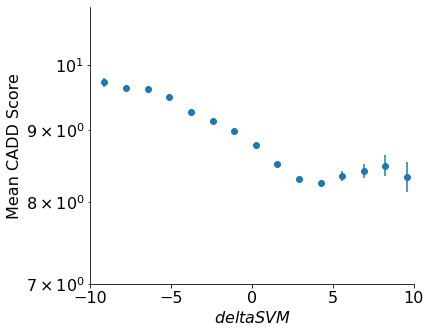

In [9]:
plt.figure(figsize=(11, 9))
plt.rcParams.update({'font.size': 16})

def plot_scatter(x, xlab, title):
    plt.scatter(x=statsDict[x]['bins'], y=statsDict[x]['CADD'])
    plt.errorbar(x=statsDict[x]['bins'], y=statsDict[x]['CADD'], yerr=statsDict[x]['ci'], ls='none')
    plt.yscale("log")
    plt.xlabel(xlab)
    plt.ylabel('Mean CADD Score')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
#     plt.title(title)

plt.subplot(221)
plt.xlim((-10,10))
plt.ylim((7.000, 11))
plot_scatter('DSVM', '$\it{deltaSVM}$', 'Raw deltaSVM vs CADD')


# plt.subplot(222)
# plot_scatter('PHRED', 'Scaled deltaSVM', 'Scaled deltaSVM vs gnomAD AF')

# plt.subplot(223)
# plot_scatter('ABS_DSVM', '|deltaSVM|', 'absval deltaSVM vs gnomAD AF')
# plt.xlim((0,6))
# plt.ylim((0.002,0.008))

# plt.subplot(224)
# plot_scatter('ABS_PHRED', 'Scaled |deltaSVM|', 'Scaled absval deltaSVM vs gnomAD AF')

plt.tight_layout()
plt.savefig('/active/cherry_t/Leah/Analyses/gkm_svm/RandNeg_analysis/AltKernel/CADD_binnedDSVM_scatter.pdf')
plt.show()